In [1]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [2]:
import pandas as pd
import numpy as np
from functools import reduce

In [3]:
seq = pd.read_csv("data/raw/peptide_target_seq.csv")

In [4]:
seq.head(2)

,Sequence,Abbreviation,Target,Target_domain,Target_seq
0,VSTALPQWRIYSYAGDNI,HCV,Virus entry,"HCV glycoproteins: E1, E2",YQVRNSSGLYHVTNDCPNSSVVYEAADAILHTPGCVPCVREGNASR...
1,ALPQWRIYSYAGDNIVTA,HCV,Virus entry,"HCV glycoproteins: E1, E2",YQVRNSSGLYHVTNDCPNSSVVYEAADAILHTPGCVPCVREGNASR...


In [5]:
zscales = pd.read_csv("data/raw/z_scales_5.csv")

In [6]:
zscale_dict = dict(zip(zscales["1-letter-code"], zscales[["z1", "z2", "z3", "z4", "z5"]].values.tolist()))

In [7]:
def get_aa_zscales(aa, zscale_df = zscales):
    # row = zscale_df[zscale_df["1-letter-code"] == aa]
    # return row[["z1", "z2", "z3", "z4", "z5"]].values.tolist()[0]
    # very slow with above code. roughly 1000x faster with dict
    # because searching in dict is only O(1) operation
    return zscale_dict[aa]

In [8]:
def get_seq_zscales(seq):
    seq = list(seq)
    #seq_zscales = reduce(lambda l1, l2: [a+b for a, b in zip(l1, l2)], map(get_aa_zscales, s))
    zscales_values = np.array(list(map(get_aa_zscales, seq)))
    return zscales_values.sum(axis=0)

In [11]:
def cross_seq_term_zscales(zscales1, zscales2):
    return np.multiply.outer(zscales1,zscales2).flatten().tolist()

In [12]:
def get_zscale_features(peptide_zscales, target_zscales):
    
    assert peptide_zscales.shape == target_zscales.shape
    
    zscale_features = pd.concat([peptide_zscales, target_zscales], axis=1)
    tmp = zscale_features.apply(lambda row: cross_seq_term_zscales(
        row[["p_z1", "p_z2", "p_z3", "p_z4", "p_z5"]].values,
        row[["t_z1", "t_z2", "t_z3", "t_z4", "t_z5"]].values
    ), axis=1, result_type='expand')
    cross_term_cols = ["x_z"+str(i) for i in range(1,26)]
    zscale_features[cross_term_cols] = tmp
    
    return zscale_features

In [9]:
peptide_zscales = seq.apply(lambda row: get_seq_zscales(row["Sequence"]), axis=1, result_type='expand')
peptide_zscales.columns = ["p_z"+str(i) for i in range(1,6)]

In [10]:
target_zscales = seq.apply(lambda row: get_seq_zscales(row["Target_seq"]), axis=1, result_type='expand')
target_zscales.columns = ["t_z"+str(i) for i in range(1,6)]

In [19]:
from sklearn.preprocessing import StandardScaler

In [26]:
pep_scaler = StandardScaler()
peptide_zscales_scaled = pep_scaler.fit_transform(peptide_zscales)
peptide_zscales_scaled = pd.DataFrame(peptide_zscales_scaled, columns=peptide_zscales.columns)

In [27]:
target_scaler = StandardScaler()
target_zscales_scaled = target_scaler.fit_transform(target_zscales)
target_zscales_scaled = pd.DataFrame(target_zscales_scaled, columns=target_zscales.columns)

In [29]:
zscale_features = get_zscale_features(peptide_zscales_scaled, target_zscales_scaled)
zscale_features

,p_z1,p_z2,p_z3,p_z4,p_z5,t_z1,t_z2,t_z3,t_z4,t_z5,...,x_z16,x_z17,x_z18,x_z19,x_z20,x_z21,x_z22,x_z23,x_z24,x_z25
0,-0.214447,0.543944,0.450385,-0.463872,0.555002,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.500376,-0.404509,-0.610980,-0.588496,0.539526,-0.598678,0.483978,0.731010,0.704110,-0.645520
1,-0.330024,0.449489,0.388040,-0.323230,0.676401,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.348666,-0.281865,-0.425736,-0.410069,0.375946,-0.729629,0.589840,0.890908,0.858123,-0.786717
2,-1.498161,-0.353008,0.324560,-0.016067,0.720721,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.017331,-0.014011,-0.021162,-0.020384,0.018687,-0.777437,0.628489,0.949283,0.914350,-0.838266
3,-1.254105,-1.156260,-0.225215,-0.205090,0.092533,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.221229,-0.178844,-0.270130,-0.260190,0.238539,-0.099814,0.080691,0.121877,0.117392,-0.107624
4,-0.971344,-0.371899,0.644224,-0.061072,0.608957,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.065879,-0.053257,-0.080440,-0.077480,0.071033,-0.656878,0.531028,0.802076,0.772560,-0.708274
5,-1.022413,-1.107143,-0.001904,-0.451495,-0.044281,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.487025,-0.393717,-0.594678,-0.572795,0.525131,0.047766,-0.038615,-0.058324,-0.056178,0.051504
6,-0.789108,0.027082,-0.021175,0.138077,0.053993,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,-0.148943,0.120407,0.181865,0.175173,-0.160596,-0.058242,0.047084,0.071116,0.068499,-0.062799
7,-1.015962,-0.072663,0.012832,0.348478,0.450947,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,-0.375901,0.303882,0.458991,0.442100,-0.405312,-0.486433,0.393238,0.593956,0.572098,-0.524493
8,-1.730928,-0.679447,0.263348,-0.226468,0.755406,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.244289,-0.197486,-0.298288,-0.287311,0.263403,-0.814852,0.658735,0.994968,0.958354,-0.878608
9,-1.373982,-0.343940,0.216872,-0.310853,1.100331,-1.078694,0.872028,1.317130,1.268661,-1.163094,...,0.335315,-0.271073,-0.409434,-0.394367,0.361551,-1.186921,0.959520,1.449280,1.395948,-1.279788


### EDA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA()

In [16]:
X_transform = pca.fit_transform(zscale_features)

In [17]:
import matplotlib.pyplot as plt

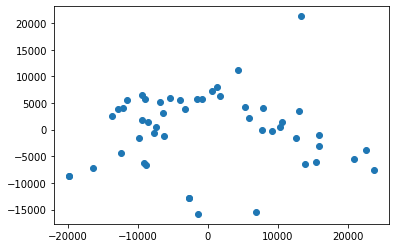

In [18]:
plt.scatter(X_transform[:,0], X_transform[:,1])